In [1]:
import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
 
warnings.filterwarnings("ignore")
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.dataprocessing.transformers import Scaler
import logging

mpl.rcParams['figure.dpi'] = 300
logging.disable(logging.CRITICAL)

In [2]:
edata = pd.read_csv("energydata.csv")

In [3]:
edata['date']= pd.to_datetime(edata['date'])

In [4]:
edata['hour']=edata['date'].dt.hour
edata['dayofweek']=edata['date'].dt.dayofweek
edata['month']=edata['date'].dt.month
edata['year']=edata['date'].dt.year
edata['weekofyear']=edata['date'].dt.weekofyear

In [5]:
edata= edata.set_index('date').resample('H').mean().reset_index() #aggregating into hourly basis

In [6]:
edata.drop(['rv1','rv2'], axis=1, inplace=True)

In [7]:
ed_darts= edata[['date', 'appl']]

In [8]:
ed_darts.head()

,date,appl
0,2016-01-11 17:00:00,55.000000
1,2016-01-11 18:00:00,176.666667
2,2016-01-11 19:00:00,173.333333
3,2016-01-11 20:00:00,125.000000
4,2016-01-11 21:00:00,103.333333


In [9]:
series= TimeSeries.from_dataframe(ed_darts, time_col='date')

In [10]:
#ed_darts.set_index('date', inplace=True)

In [11]:
series

<TimeSeries (DataArray) (date: 3290, component: 1, sample: 1)>
array([[[ 55.        ]],

       [[176.66666667]],

       [[173.33333333]],

       ...,

       [[135.        ]],

       [[180.        ]],

       [[430.        ]]])
Coordinates:
  * date       (date) datetime64[ns] 2016-01-11T17:00:00 ... 2016-05-27T18:00:00
  * component  (component) object 'appl'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [104]:
#start = pd.Timestamp('2016-01-11 17:00:00')
ed_dts_metrics = pd.DataFrame()

def plot_backtest(series, forecast, model_name):
    idx = 0
    series[idx:].plot(label='Actual Values')
    forecast[idx:].plot(label= 'Forecast')
    plt.title(model_name)
    plt.show()
    
def print_metrics(series, forecast, model_name):
    mae_ = mae(series, forecast)
    rmse_ = rmse(series, forecast)
    mape_ = mape(series, forecast)
    smape_ = smape(series, forecast)
    r2_score_ = r2_score(series, forecast)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_, 
             'R2': r2_score_}
    
    ed_darts= pd.DataFrame(dict_, index = [model_name])
    
    return(ed_darts.round(decimals = 2))

  0%|          | 0/1646 [00:00<?, ?it/s]

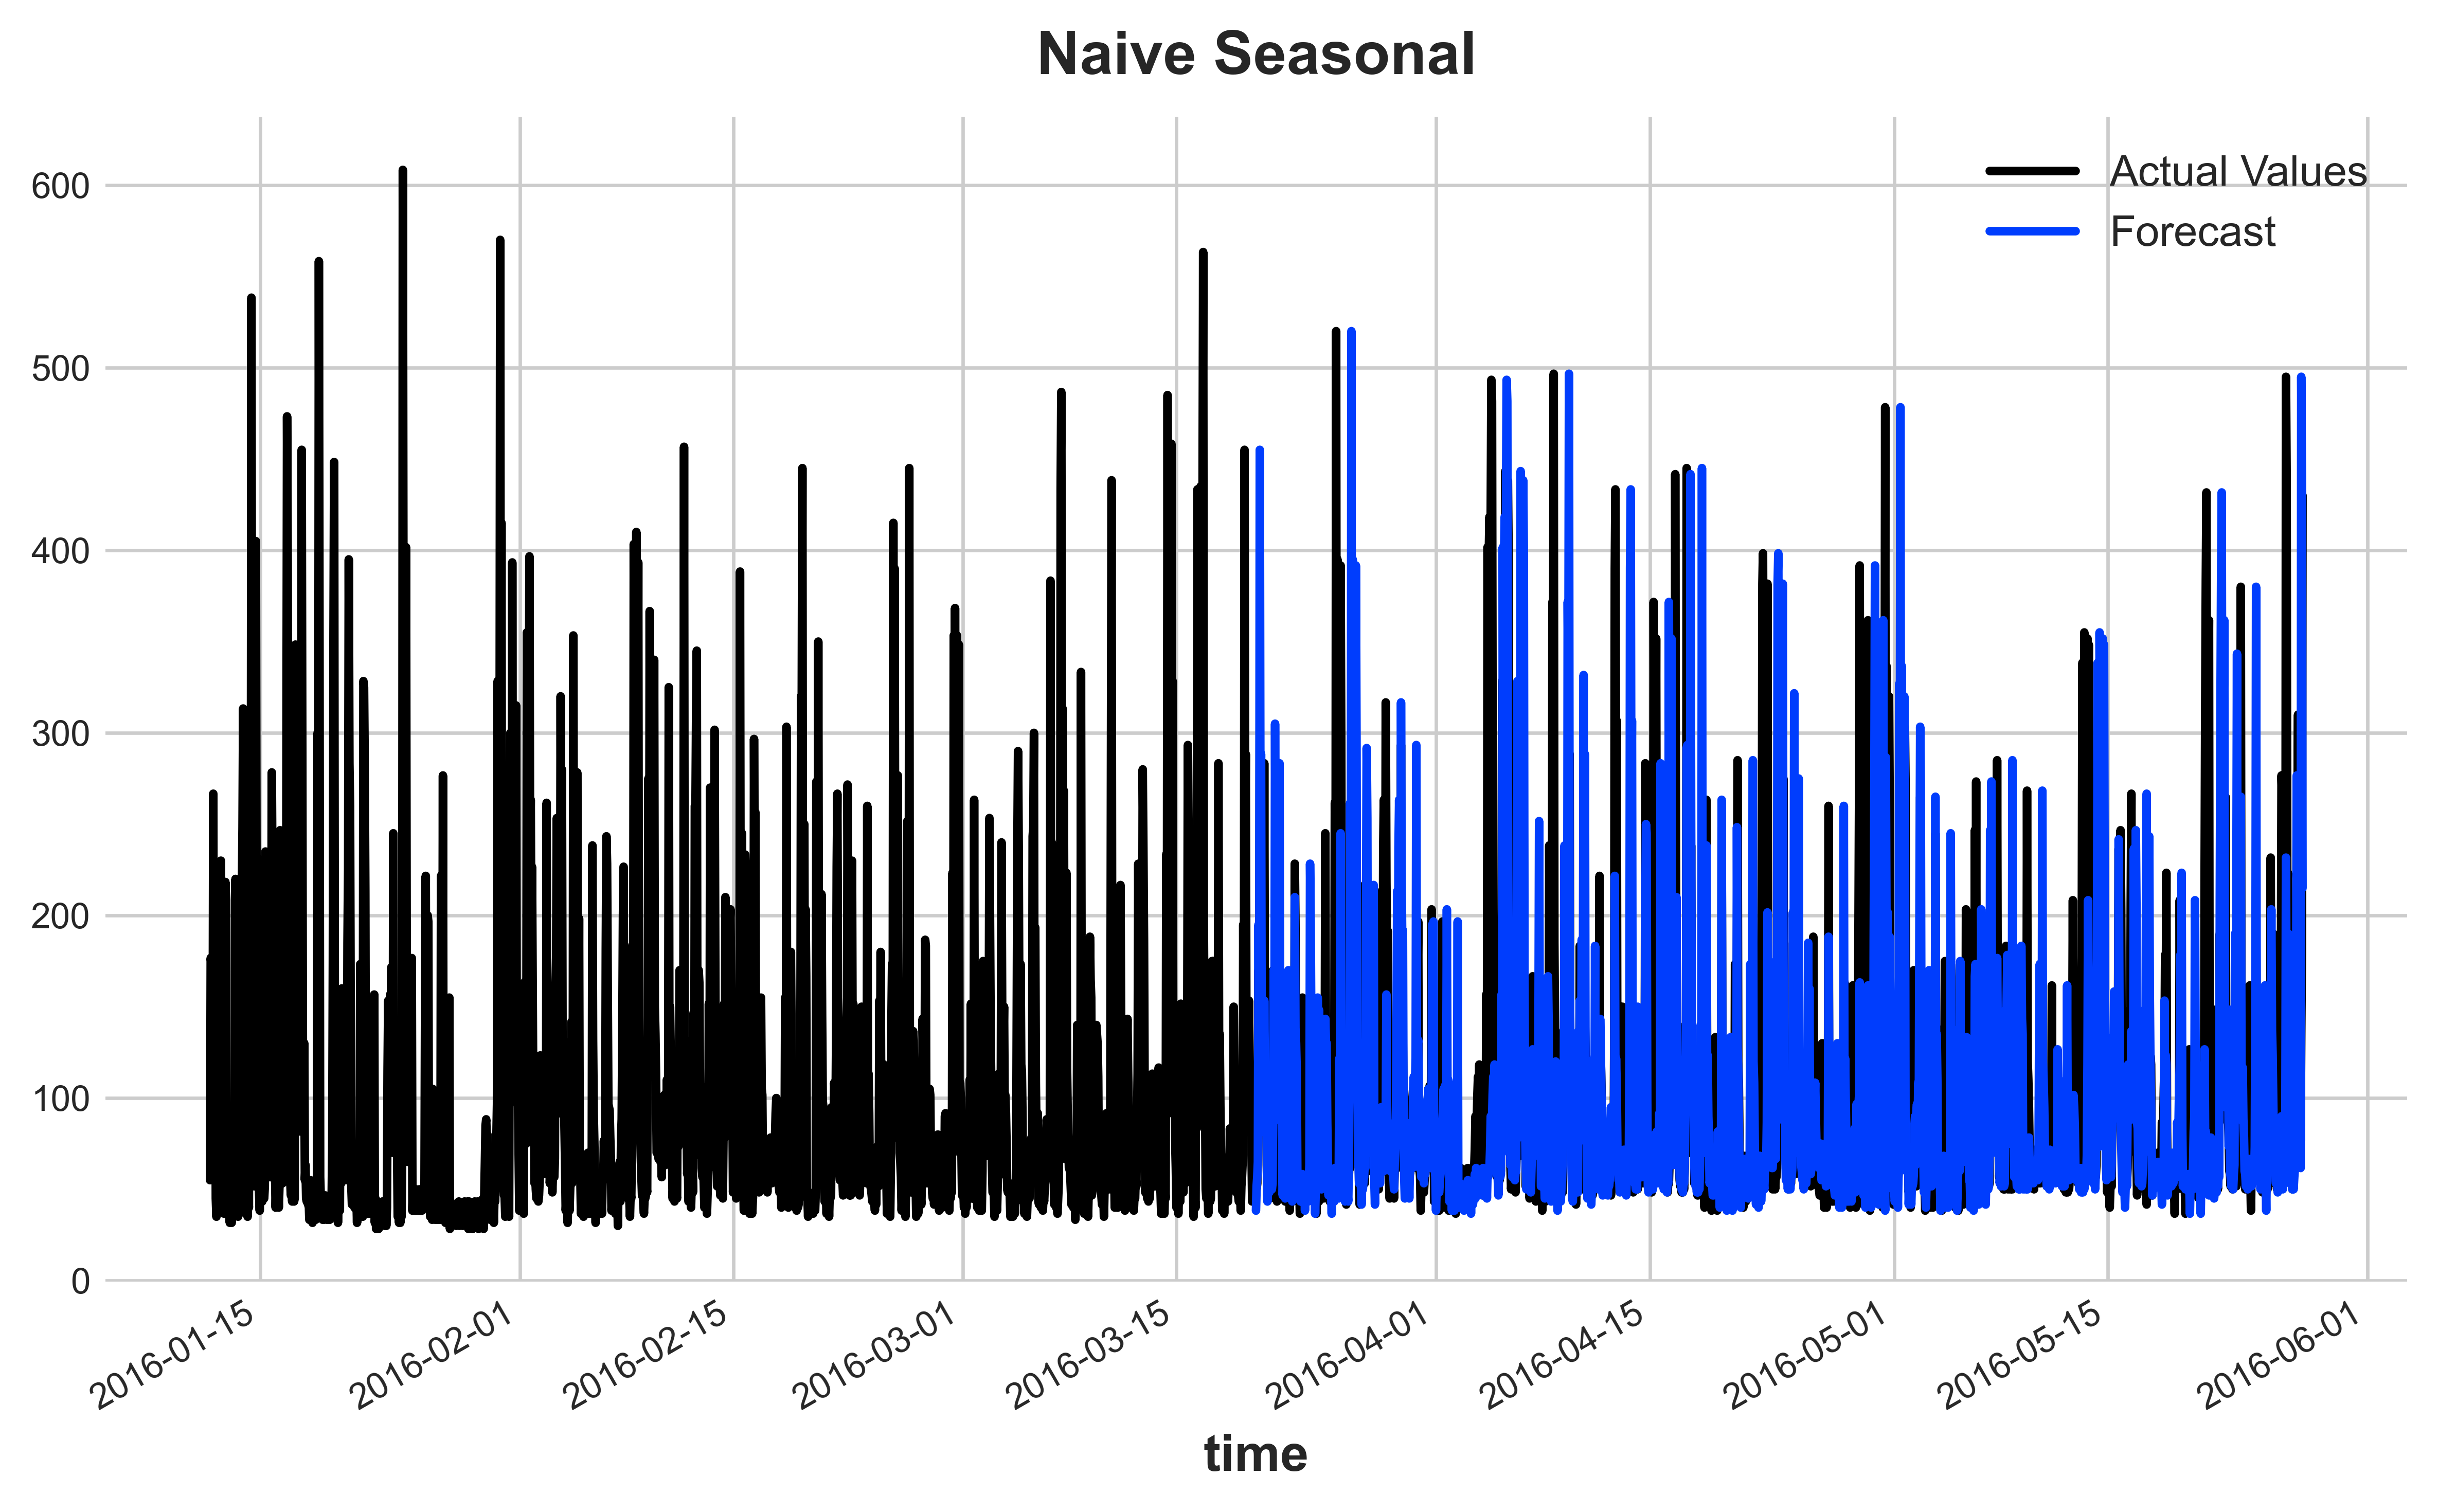

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,47.39,87.68,43.63,35.63,-0.34


In [112]:
model = NaiveSeasonal(K = 24)
model_name = 'Naive Seasonal'

plt.figure(figsize = (8, 5))
forecast = model.historical_forecasts(series, forecast_horizon=1, verbose=True)
plot_backtest(series, forecast, model_name)
ed_darts_naive = print_metrics(series, forecast, model_name)
#ed_darts_metrics = ed_darts_metrics.append(ed_darts_naive)

plt.show()
ed_darts_naive


## Holt Winter exponential forecasting

  0%|          | 0/1646 [00:00<?, ?it/s]

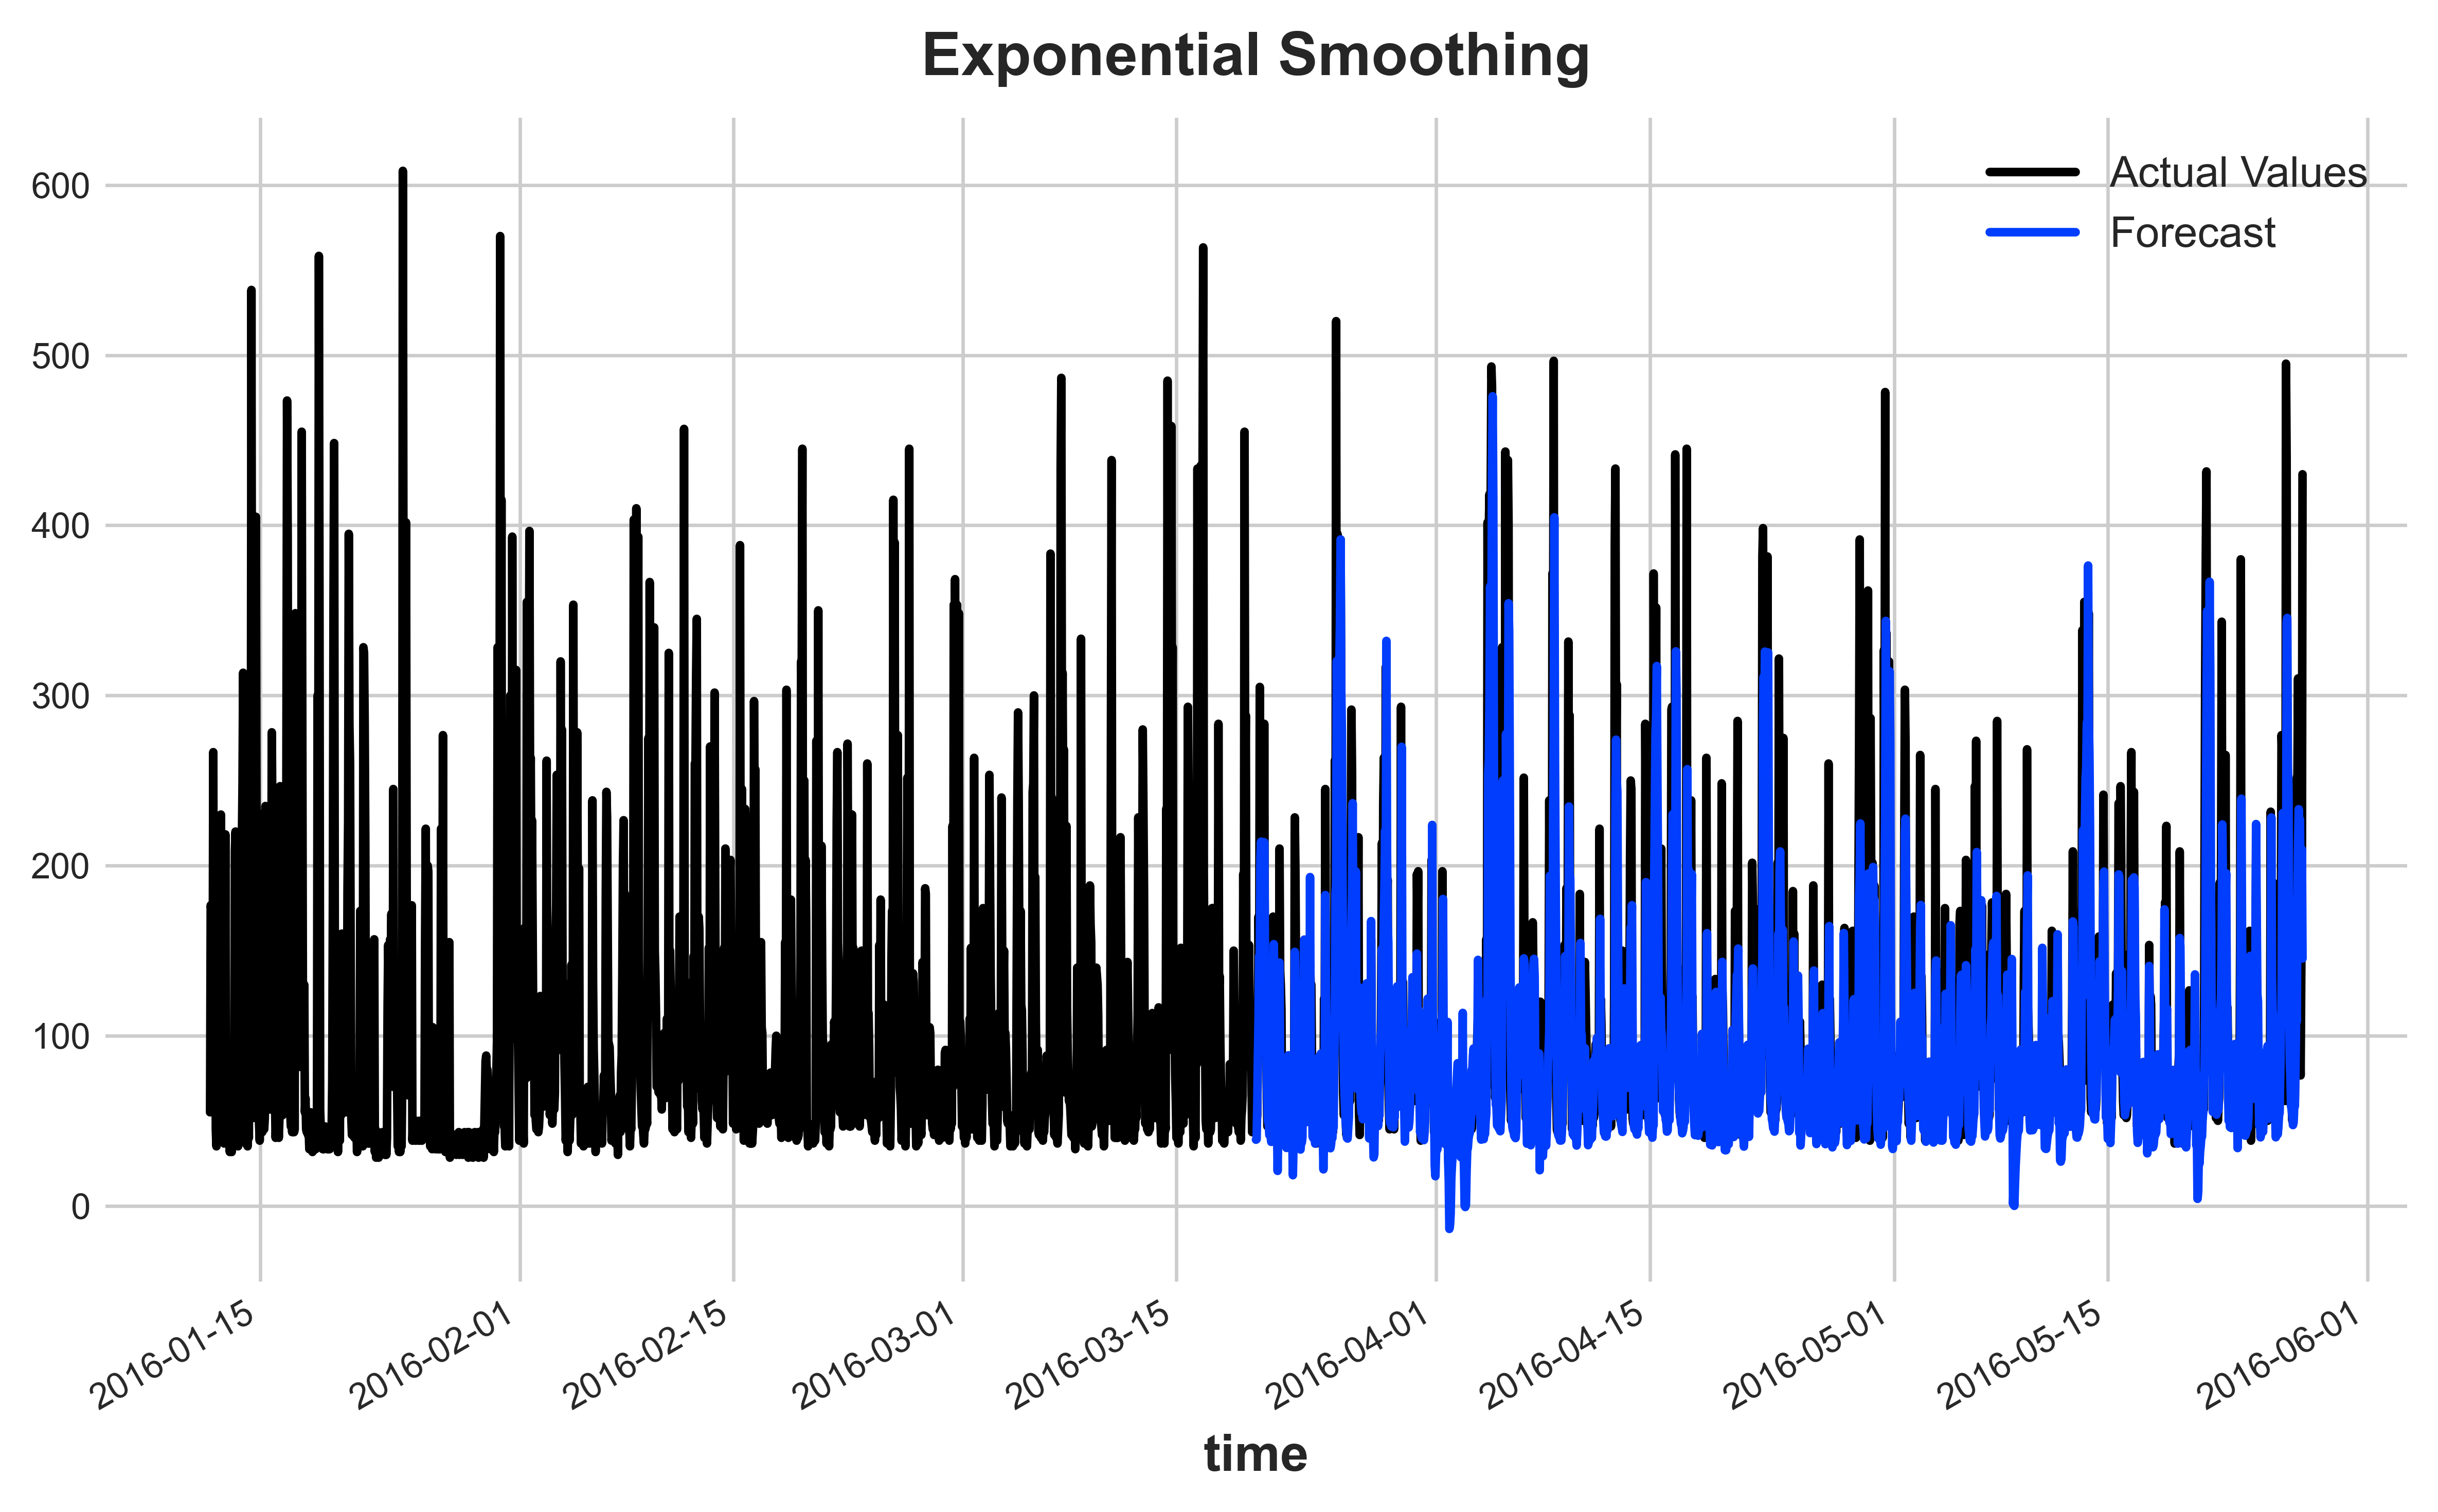

,MAE,RMSE,MAPE,SMAPE,R2
Exponential Smoothing,35.18,58.5,34.07,33.04,0.4


In [113]:
model = ExponentialSmoothing(seasonal_periods = 24)
model_name = 'Exponential Smoothing'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, forecast_horizon=1, verbose=True)
plot_backtest(series, forecast, model_name)
ed_darts_exp = print_metrics(series, forecast, model_name)
#ed_darts_metrics = ed_darts_metrics.append(ed_darts_exp)

plt.show()
ed_darts_exp

## Linear Regression forecasting

  0%|          | 0/1646 [00:00<?, ?it/s]

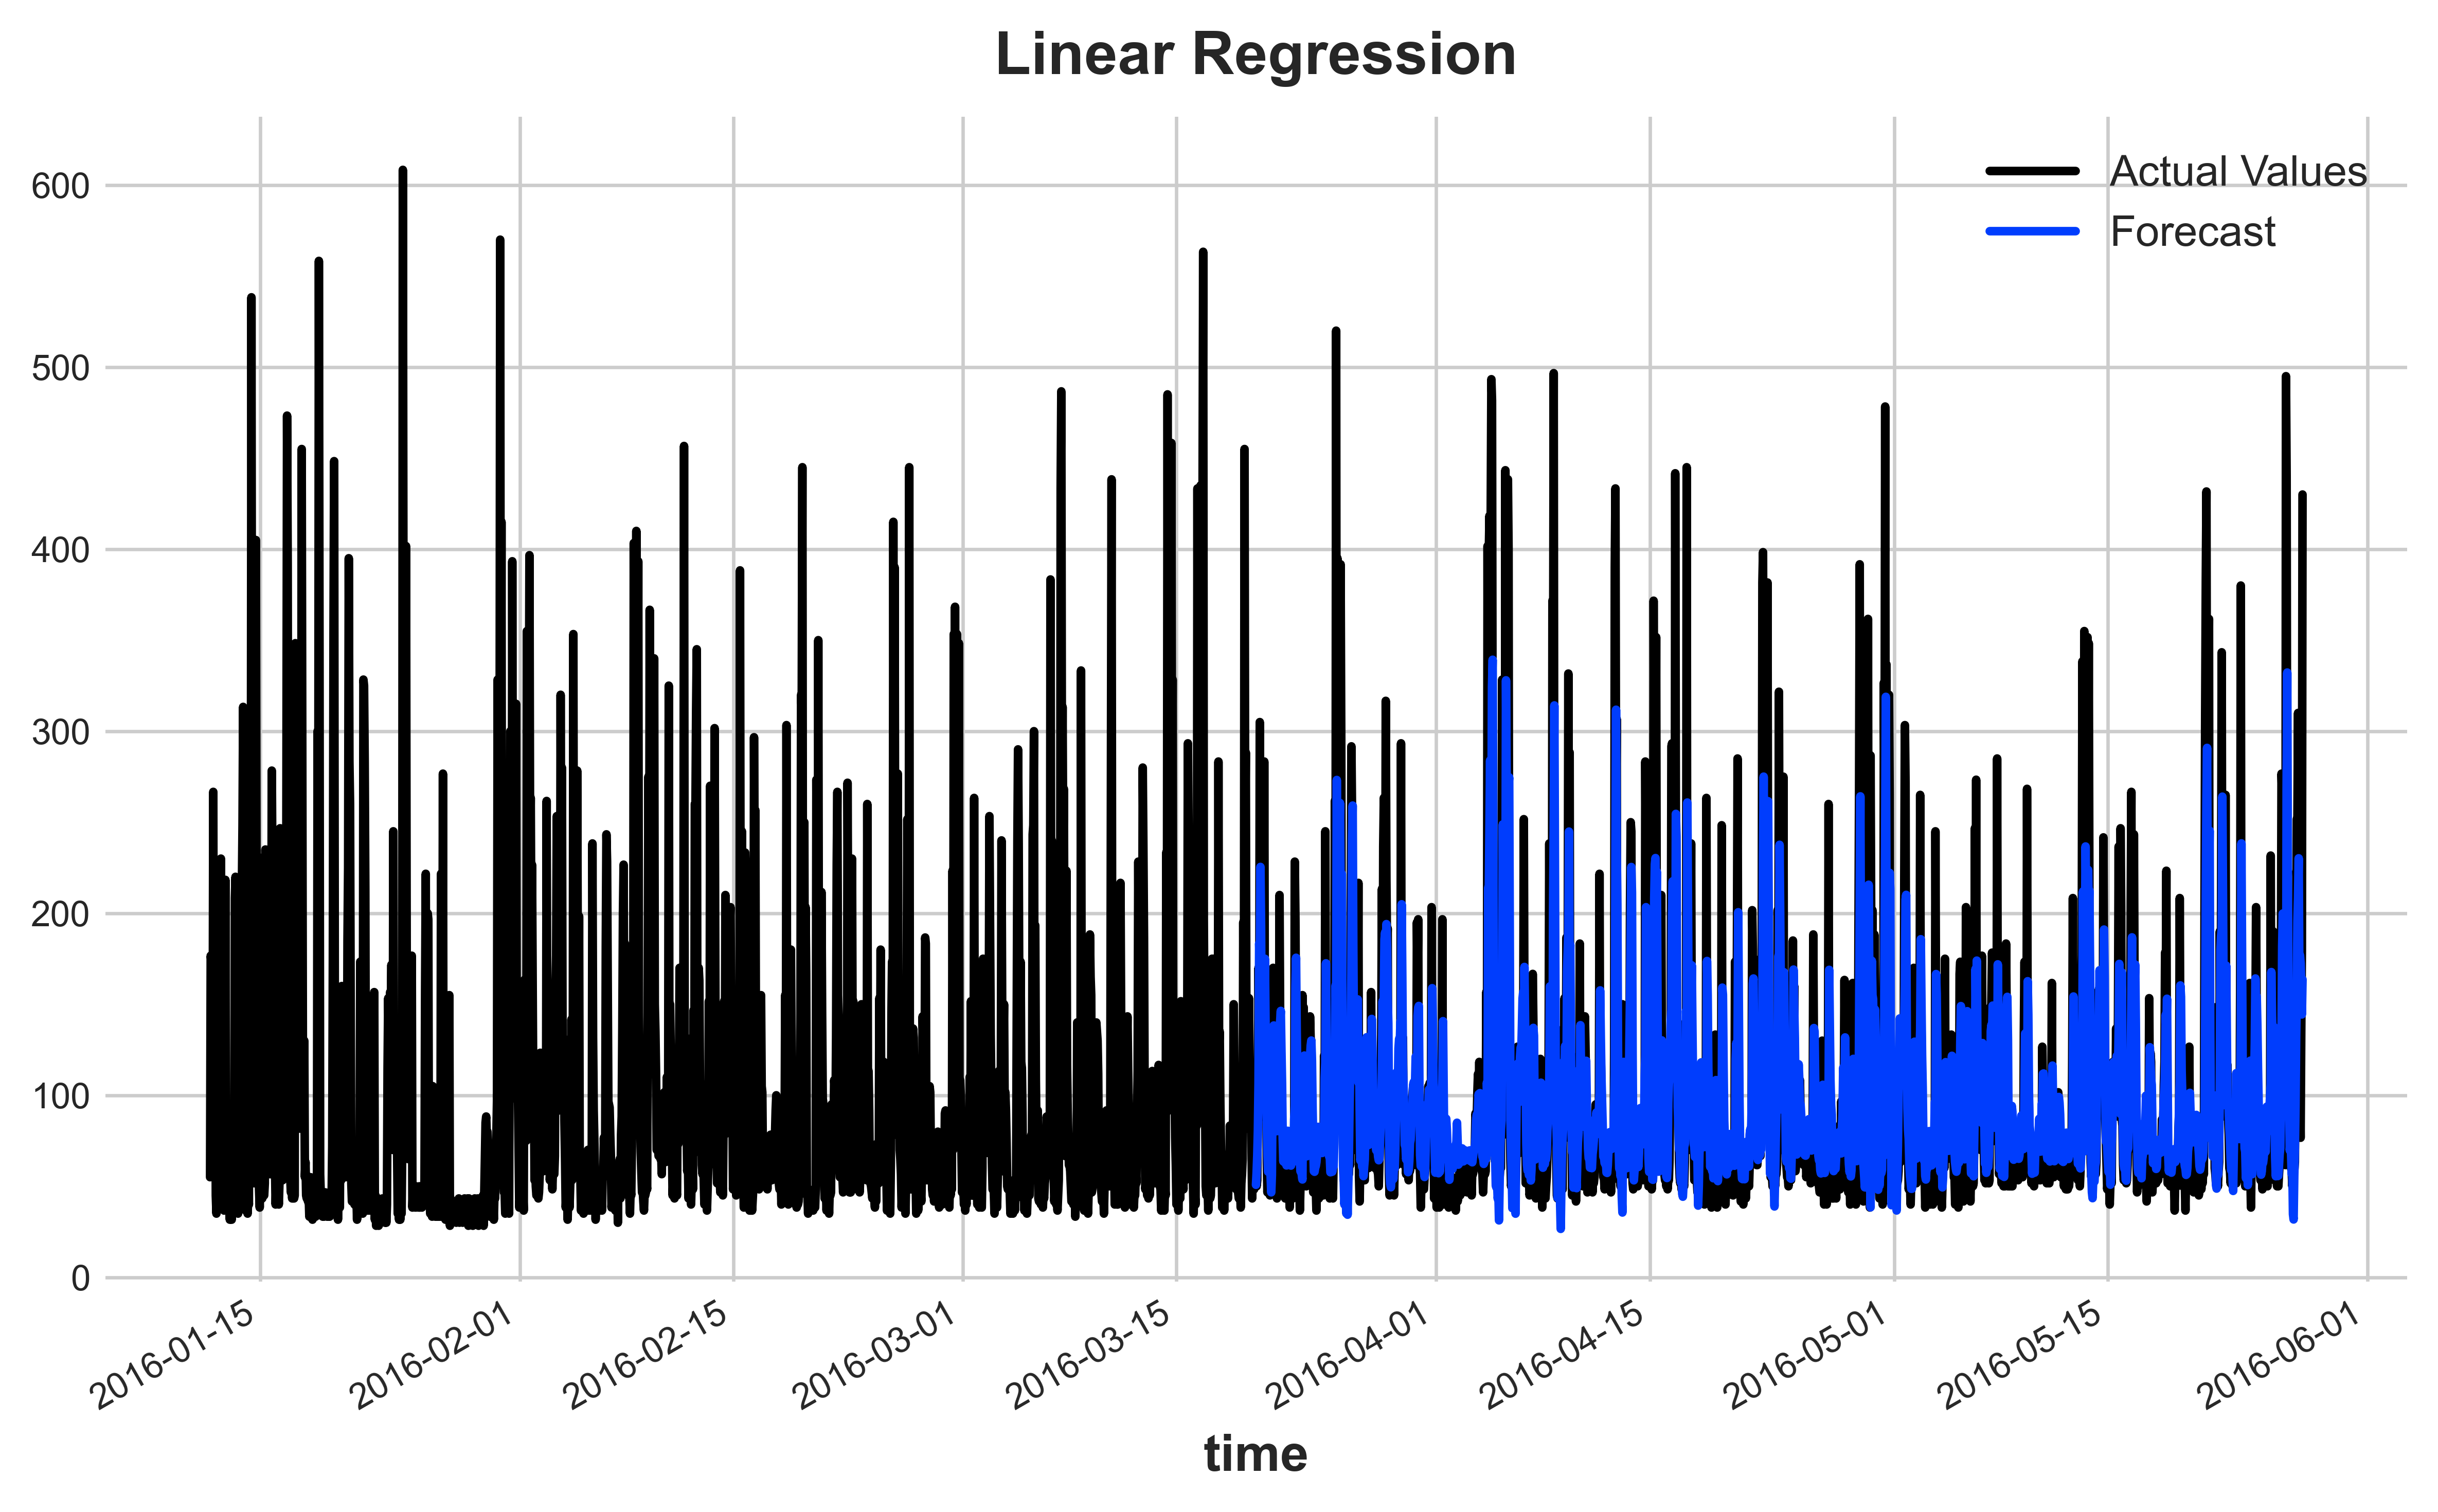

,MAE,RMSE,MAPE,SMAPE,R2
Linear Regression,33.74,57.12,32.54,29.2,0.43


In [111]:
model = LinearRegressionModel(lags = 24)
model_name = 'Linear Regression'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, forecast_horizon=1, verbose=True)
plot_backtest(series, forecast, model_name)
ed_darts_lr = print_metrics(series, forecast, model_name)
#ed_darts_metrics = df_metrics.append(ed_darts_lr)

plt.show()
ed_darts_lr